# Optimization final project

Kenwan Cheung, Joan Lee, Chantel Miller, Anthony Smaniotto.

### Background: 
As computing power and data size have grown exponentially in the past decade there has been a massive improvement in the accuracy and complexity of neural networks. While theorized by Minksy and others in the 60s, it was the breakthrough in the early 1980s by Geoffrey Hinton and his co-authors with the development of “back-propogation” that enabled development of deeper networks. When combined with the improvements in raw computing power and scale of data, we’ve seen neural networks become proficient at a variety of tasks, from image recognition to beating the best human players in the game of Go.

### Problem: 

As neural networks have gotten deeper and more complex, parameter estimation and the relevant optimization methodology is now a critical step to building neural networks.

At a simple level, neural networks could be thought of as a host of regressions set up in m-layers. We must figure out the weights of each one of those connections. In the simple example below with just one set of hidden layers, The number of parameters to be estimated is calculated by the sum of the product of the numbers of nodes in connected layers. Parameters: (3×4)+(4×2)=20. 

We can intuitively see how quickly the parameter estimation process grows. Many of the advances in the past decade have come hand in hand with advances in the optimization methods used to optimize the parameter estimation and improve time to convergence. 

### Our goal: 

Our team will seek to hand-code neural networks while implementing several of the most common optimization methods such as: stochastic gradient descent, Adagrad, ADAM. We will seek to gain a deeper understanding over how they converge by leveraging the age old Francisco™ method: simulation, development of our own functions, and visualization. We will complete this in Python.


In [1]:
# IMPORT PACKAGES

# Import relevant packages

%matplotlib inline
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV,KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from imutils import paths
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv2D, ZeroPadding2D
from keras.optimizers import RMSprop, adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils,to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.metrics import binary_accuracy,binary_crossentropy
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.regularizers import l2 # L2-regularisation
from keras.layers.normalization import BatchNormalization # batch normalisation
from sklearn import svm
import random 
import argparse
import datetime
import imutils
import cv2
import os
import re
import shutil
from IPython.display import Image
K.set_image_dim_ordering('th')


C:\Users\cmill\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Part 1

Simulation of the dataset.

Let's begin by simulating a simple data generation process.

Let's simulate a multivariate normal distribution. We might use a logistic regression in this scenario.

In [2]:
# set seed
np.random.seed(12)
n = 10000

x_1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], n)
x_2 = np.random.multivariate_normal([1, 4], [[2, .75],[.75, 2]], n)
x_3 = np.random.multivariate_normal([2, 8], [[3, .75],[.75, 3]], n)

simulated_separableish_features = np.vstack((x_1, x_2, x_3)).astype(np.float32)
y = np.hstack((np.zeros(n),
               np.ones(n),
              np.ones(n)+1))


In [3]:
print(x_1.shape,x_2.shape,x_3.shape)
print(y.shape)

(10000, 2) (10000, 2) (10000, 2)
(30000,)


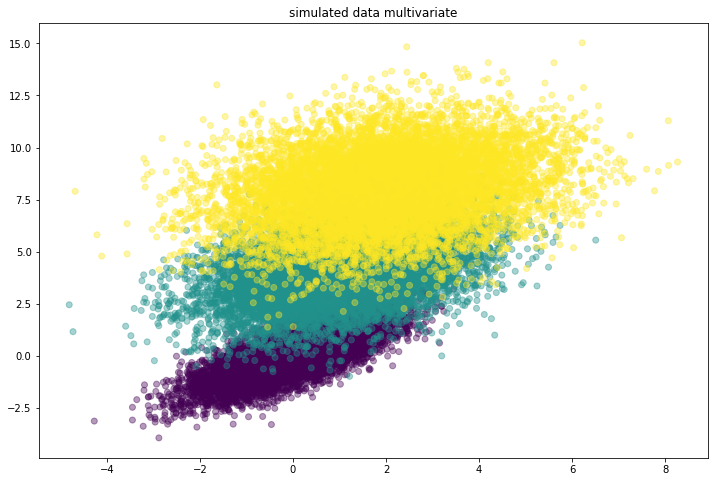

In [4]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = y, alpha = .4)
plt.title("simulated data multivariate")

# Part 2

Let's begin by setting up a function for a small NN.

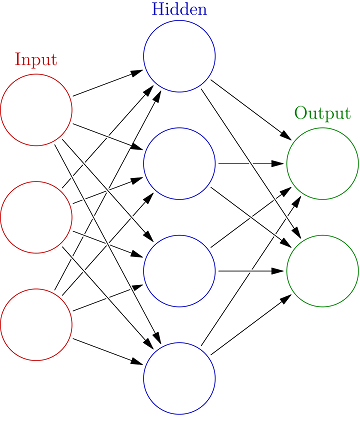

In [5]:
Image("../optimization_final/raw/neural_network_hidden.png")

### Discussion of how to build a neural net.

Neural  nets at their core are typically built around sigmoid functions. The biggest discrepancy with a more traditional approach would be the rise of "hidden" layers whose weights we are trying to calculate.

    1) Input layer weights - just like we would for a logistic regression. 
    2) We develop a hidden layer around some "activation function". Originally these were sigmoid functions, but advancements have been made to move away from the sigmoid (how our own neurons work), to something like the ReLu.
    3) Go from hidden layer to outputs layer.
    4) Translate output layer to output values with a probability distribution. Typically softmax. 

In a traditional logistic regression, the optimization occurs around the log-likelihood, which we try and maximize given a series of coefficients.

#### Log-Likelihood optimization
$ll =  \sum_{i=1}^N y_i\beta^Tx_i - log(1+e^{\beta^Tx_i})$


#### Neural network optimization
We can think about neural nets as something similar. We must optimize the errors around a particular set of weights for each layer. We do this iteratively until we reach some threshold of tolerance.



# Building our networks

In order for us to build our network, we'll need several things:

    1) initialize arrays with the correct size.
    2) set up an activation fx
    3) set up a output function
    4) set up a loss function
    5) set up back propogation / gradient passing to allow the network to adjust the next iteration. In a sense we're calculating the error as each coefficient changes. Or the derivative of the error with respect to a given weight.
    
### Setting up the shape of our arrays

We need to ensure our matrices line up! We need to do the following matrix multiplications:

    1) We start with random weights * input of shape (n * features)
    2) So our weights array must have shape of (features * hidden nodes)
    3) Bias term has shape of (1, number of hidden nodes)

Next layer for hidden. 
    
    4) weights now must be of shape (hidden nodes * num_labels)
    5) bias term is now (1, # of labels)

In [6]:
hidden_nodes = 5
num_features = 2
num_labels = 3

In [7]:
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer1_biases_array = np.zeros((1, hidden_nodes))

layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 
layer2_biases_array = np.zeros((1, num_labels))


### Activation fx

Original nets modeled their construction on a sigmoid after finding that is how our own physiology was designed. However, mnewer work has come on modified sigmoid fx that help to speed up convergence.

In this case ReLu (rectified linear unit) has a value of 0 and then a linear increase past 0, which helps dead neurons to stay dead, and speed up how quickly we find optimal weights

$f(x)=x^{+}=\max(0,x)$

In [8]:
def relu_activation(data_array):
    return np.maximum(data_array, 0)

### Softmax - from output layer to output itself.

The softmax allows us to transform a given output layer to an actual distribution, and corresponding output classification.

$\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}} for j = 1, …, K $

In [9]:
def softmax(output_array):
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis = 1, keepdims=True)

### Loss function

We need some way to evaluate each series of estimates. We will use cross entropy given we're looking at a classification issue and want some binary decision rather than that of a squared distance metric.

$H(p,q)=-\sum _{x}p(x)\,\log q(x)$

In [10]:
def cross_entropy_softmax_loss_array(softmax_probs_array, y_onehot):
    indices = np.argmax(y_onehot, axis = 1).astype(int)
    predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
    log_preds = np.log(predicted_probability)
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

### Regularization 

While not necessary, this step also helps to prevent overfitting. We'll also implement some additional overfit steps in the later steps.

In [11]:
def regularization_L2_softmax_loss(reg_lambda, weight1, weight2):
    weight1_loss = 0.5 * reg_lambda * np.sum(weight1 * weight1)
    weight2_loss = 0.5 * reg_lambda * np.sum(weight2 * weight2)
    return weight1_loss + weight2_loss


### Back propagation

For EACH layer, we are looking to see the error gradient with respect to the previous. 

So, the error gradient for layer2_weights_array would be the hidden_layer values times the error signal of the softmaxed output_layer.

Hinton et al. established that the error signal at the end of a given layer is the matrix multiplication of the error signal from the next layer in the network (say the output layer in layer2_weights_array) and the transpose of the weights coming out of the current layer (hidden layer). 

This is then multiplied by the derivative of the layer’s activation function (relu).

In [12]:
# # Allows us to calculate the loss at a given layer
# output_error_signal = (output_probs - labels_onehot) / output_probs.shape[0]

# # derivative of activation function from above.
# error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
# error_signal_hidden[hidden_layer <= 0] = 0

# # updated gradient
# gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
# gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

# # now flow through to layer 1
# gradient_layer1_weights = np.dot(data.T, error_signal_hidden)
# gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

# # regularization.
# reg_lambda = .01
# learning_rate = .01

# gradient_layer2_weights += reg_lambda * layer2_weights_array
# gradient_layer1_weights += reg_lambda * layer1_weights_array

# layer1_weights_array -= learning_rate * gradient_layer1_weights
# layer1_biases_array -= learning_rate * gradient_layer1_bias
# layer2_weights_array -= learning_rate * gradient_layer2_weights
# layer2_biases_array -= learning_rate * gradient_layer2_bias


In [13]:
# accuracy
def accuracy(predictions, labels):
    preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy

# Now coding up the exact algorithm

First let's segment our data into train and test.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(simulated_separableish_features, y, test_size=0.2, random_state=42)

In [15]:
y_train

array([ 2.,  0.,  2., ...,  0.,  1.,  2.])

In [16]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

## Batch Gradient Descent

Training on the full data set at once.

In [17]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = .01
reg_lambda = .01

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for step in range(0,n+1):

    input_layer = np.dot(X_train, layer1_weights_array)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
    loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

    output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * layer1_weights_array

    layer1_weights_array -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))


Loss at step 0: 4.657260612282798
Loss at step 500: 0.8078146405969078
Loss at step 1000: 0.6998840510118463
Loss at step 1500: 0.5971640912177806
Loss at step 2000: 0.4712946254508485
Loss at step 2500: 0.40773455208877624
Loss at step 3000: 0.3770794105115386
Loss at step 3500: 0.3585366721856978
Loss at step 4000: 0.3459676975944171
Loss at step 4500: 0.3367836618060268
Loss at step 5000: 0.32963434177632894
Loss at step 5500: 0.3237548679028889
Loss at step 6000: 0.3187719686629699
Loss at step 6500: 0.31446061086796867
Loss at step 7000: 0.3106679471956684
Loss at step 7500: 0.3073022401884193
Loss at step 8000: 0.30427810318539217
Loss at step 8500: 0.3015560756340227
Loss at step 9000: 0.29909082392674086
Loss at step 9500: 0.2968649259131479
Loss at step 10000: 0.29484804420810745


### Shape of some outputs

In [18]:
output_probs

array([[  5.42305267e-08,   1.64001802e-03,   9.98359928e-01],
       [  9.88224015e-01,   1.15266061e-02,   2.49379299e-04],
       [  1.39598460e-04,   2.02608391e-01,   7.97252010e-01],
       ..., 
       [  9.72585645e-01,   2.30432679e-02,   4.37108680e-03],
       [  7.60028523e-03,   9.33023276e-01,   5.93764390e-02],
       [  5.70196987e-04,   4.28681557e-01,   5.70748246e-01]])

In [19]:
loss

0.29484804420810745

In [20]:
output_error_signal

array([[  2.25960528e-12,   6.83340841e-08,  -6.83363437e-08],
       [ -4.90666058e-07,   4.80275254e-07,   1.03908041e-08],
       [  5.81660251e-09,   8.44201630e-06,  -8.44783290e-06],
       ..., 
       [ -1.14226478e-06,   9.60136164e-07,   1.82128617e-07],
       [  3.16678551e-07,  -2.79069684e-06,   2.47401829e-06],
       [  2.37582078e-08,   1.78617315e-05,  -1.78854898e-05]])

In [21]:
error_signal_hidden

array([[  0.00000000e+00,   0.00000000e+00,   2.45320973e-08,
         -1.66211293e-07,   0.00000000e+00],
       [  2.65036320e-09,  -8.52049533e-07,   0.00000000e+00,
          0.00000000e+00,  -1.57715002e-07],
       [  0.00000000e+00,   0.00000000e+00,   3.02462165e-06,
         -2.05402433e-05,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,  -1.88903407e-06,   1.59934180e-06,
          0.00000000e+00,   0.00000000e+00],
       [ -2.81704952e-06,   0.00000000e+00,  -1.34979456e-06,
          6.41933442e-06,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   6.38695745e-06,
         -4.34726469e-05,   0.00000000e+00]])

In [22]:
gradient_layer1_weights

array([[-0.00362413,  0.00132196,  0.00243287,  0.00035975, -0.00403601],
       [-0.00190431,  0.00122508,  0.00190274, -0.00162982, -0.00460465]])

In [23]:
layer1_weights_array

array([[-0.34052562,  0.39930102, -0.09786923, -0.0625327 , -0.35951634],
       [-0.22972847, -0.57956202,  1.27042949,  0.78011416, -0.52487454]])

# Predictions

In [24]:
input_layer = np.dot(X_test, layer1_weights_array)
hidden_layer = relu_activation(input_layer + layer1_biases_array)
scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
probs = softmax(scores)
print('Test accuracy: {0}%'.format(accuracy(probs, y_test_enc)))

Test accuracy: 90.93333333333334%


### Plot of predictions

Let's compare results.

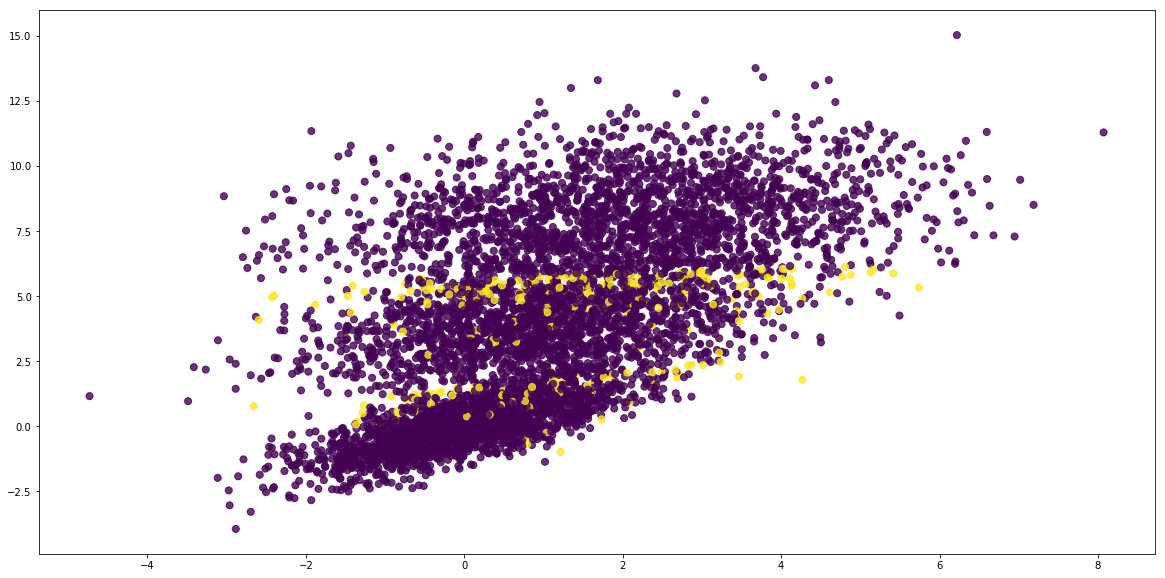

In [25]:
labels_flat = np.argmax(y_test_enc, axis = 1)
predictions = np.argmax(probs, axis = 1)
plt.figure(figsize = (20, 10))
plt.scatter(X_test[:, 0], X_test[:, 1], c = predictions == labels_flat - 1, alpha = .8, s = 50)

## Minibatch Gradient Descent

Training on the dataset in batches and updating the weights after each batch.

In [26]:
from sklearn.utils import shuffle

hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = 1e-2
reg_lambda = .01
minibatch_size = 256

loss_history = []

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

for step in range(0,n+1):
    
    X_train_rand, y_train_rand = shuffle(X_train, y_train_enc)
    
    step_loss = []
    
    #learning_rate *= 1/(1+0.01*1)
    
    # Get pair of (X, y) of the current minibatch/chunk
    for i in range(0, X_train.shape[0], minibatch_size):
        X_train_mini = X_train_rand[i:i + minibatch_size]
        y_train_mini = y_train_rand[i:i + minibatch_size]

        input_layer = np.dot(X_train_mini, layer1_weights_array)
        hidden_layer = relu_activation(input_layer + layer1_biases_array)
        output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
        output_probs = softmax(output_layer)

        loss = cross_entropy_softmax_loss_array(output_probs, y_train_mini)
        loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)
        step_loss.append(loss)

        output_error_signal = (output_probs - y_train_mini) / output_probs.shape[0]

        error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
        error_signal_hidden[hidden_layer <= 0] = 0

        gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
        gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

        gradient_layer1_weights = np.dot(X_train_mini.T, error_signal_hidden)
        gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

        gradient_layer2_weights += reg_lambda * layer2_weights_array
        gradient_layer1_weights += reg_lambda * layer1_weights_array

        layer1_weights_array -= learning_rate * gradient_layer1_weights
        layer1_biases_array -= learning_rate * gradient_layer1_bias
        layer2_weights_array -= learning_rate * gradient_layer2_weights
        layer2_biases_array -= learning_rate * gradient_layer2_bias
        
    loss_history.append(np.average(step_loss))

    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))
            #print learning_rate


Loss at step 0: 0.8508386243260105
Loss at step 500: 0.2842548803489579
Loss at step 1000: 0.2503485580322286
Loss at step 1500: 0.24111857362595507
Loss at step 2000: 0.3572629080898526
Loss at step 2500: 0.3475029389976422
Loss at step 3000: 0.2842270940341123
Loss at step 3500: 0.2430551585814563
Loss at step 4000: 0.25926524552066493
Loss at step 4500: 0.256443920607937
Loss at step 5000: 0.30301376723448953
Loss at step 5500: 0.24628924232424976
Loss at step 6000: 0.2217443386193295
Loss at step 6500: 0.29958355943476367
Loss at step 7000: 0.24372438121228246
Loss at step 7500: 0.2800733690354553
Loss at step 8000: 0.249368516009868
Loss at step 8500: 0.32311008780627765
Loss at step 9000: 0.20501084032233688
Loss at step 9500: 0.35473863081826845
Loss at step 10000: 0.2611133616944024


In [27]:
input_layer = np.dot(X_test, layer1_weights_array)
hidden_layer = relu_activation(input_layer + layer1_biases_array)
scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
probs = softmax(scores)
print('Test accuracy: {0}%'.format(accuracy(probs, y_test_enc)))

Test accuracy: 90.9%


### Results with various parameters for mini batch


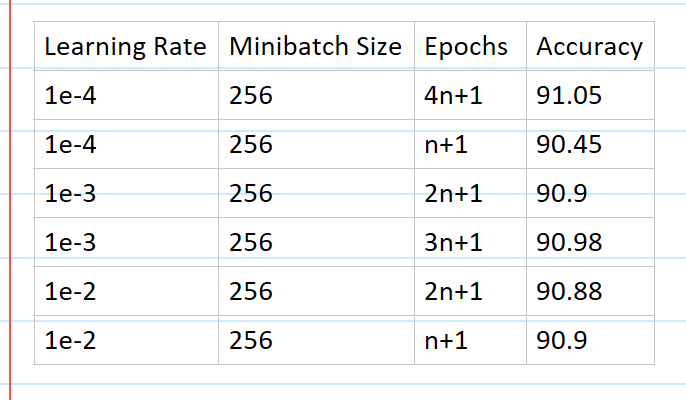

In [61]:
Image("../optimization_final/raw/minibatch_param_accuracies.png")

#### Adagrad
$G^{k} = G^{k−1} + ∇J(θ^{k−1})^2$<br>
$θ^{k} = θ^{k−1} – α / sqrt(G^{k−1}) * ∇J(θ^{k−1})$

In [28]:
from random import sample
import math
def adagrad(f_grad,
            x0,
            data,
            args,
            stepsize = 1e-2, 
            fudge_factor = 1e-6, 
            max_it=1000, 
            minibatchsize=None, 
            minibatch_ratio=0.01):
    # f_grad returns the loss functions gradient
    # x0 are the initial parameters (a starting point for the optimization)
    # data is a list of training data
    # args is a list or tuple of additional arguments passed to fgrad
    # stepsize is the global stepsize fir adagrad
    # fudge_factor is a small number to counter numerical instabiltiy
    # max_it is the number of iterations adagrad will run
    # minibatchsize if given is the number of training samples considered in each iteration
    # minibatch_ratio if minibatchsize is not set this ratio will be used to determine the batch size dependent on the length of the training data
    
    #d-dimensional vector representing diag(Gt) to store a running total of the squares of the gradients.
    gti = np.zeros(x0.shape[0])
    
    ld = len(data)
    if minibatchsize is None:
        minibatchsize = int(math.ceil(len(data)*minibatch_ratio))
    w = x0
    for t in range(max_it):
        s = sample(xrange(ld), minibatchsize)
        sd = [data[idx] for idx in s]
        grad = f_grad(w, sd, *args)
        gti += grad**2
        adjusted_grad = grad / (fudge_factor + np.sqrt(gti))
        w = w - stepsize*adjusted_grad
    return w


In [29]:
adagrad(f_grad=, x0=, data=, args=)

SyntaxError: invalid syntax (<ipython-input-29-277d8526cb12>, line 1)

In [ ]:
hidden_nodes = 5
num_labels = 3
num_features = X_train.shape[1]
learning_rate = .01
reg_lambda = .01

gti = X_train.shape[0]

# Weights and Bias Arrays
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))

w = layer1_weights_array

for step in range(0,n+1):

    input_layer = np.dot(X_train, w)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, y_train_enc)
    grad = regularization_L2_softmax_loss(reg_lambda, w, layer2_weights_array)
    loss += grad
    
    gti += grad**2
    adjusted_grad = grad / np.sqrt(gti)
    w = w - learning_rate*adjusted_grad

    output_error_signal = (output_probs - y_train_enc) / output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(X_train.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * w

    w -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    if step % 500 == 0:
            print('Loss at step {0}: {1}'.format(step, loss))
            print('Adagrad parameters are step {0}: {1}'.format(step, w))


# Testing stock versions

We'd like to compare our results to a stock version of SGD.

We'll create a keras nn with 5 hidden nodes as we've done in the hard coded example.

In [30]:
# define baseline model
def nn_model():
    # create model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [56]:
estimator = KerasClassifier(build_fn=nn_model,epochs = 10, batch_size = 10000, verbose = 0)

In [42]:
kfold = KFold(n_splits=10, shuffle=True, random_state=12)

In [57]:
%time results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Wall time: 50.2 s
Baseline: 45.36% (5.67%)


### Setting parameters to match hand coded full batch gradient descent

In the neural network terminology:

one epoch = one forward pass and one backward pass of all the training examples

batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.

number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

The below uses the full dataset as the batch size and n+1 as the number of epochs, matching the full batch gradient descent hand coded above. Time to convergence is TBD but upwards of 20 minutes.

In [59]:
estimator = KerasClassifier(build_fn=nn_model,epochs = n+1, batch_size = len(X_train), verbose = 0)

In [60]:
#%time results = cross_val_score(estimator, X_train, y_train, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))